In [8]:
import numpy as np
import scipy.fftpack
import librosa
import mygrad
import pickle
import os
from mygrad import Tensor
from mygrad.math import log
from mygrad.nnet.layers import dense
from mygrad.nnet.losses import multiclass_hinge
from mygrad.nnet.activations import softmax, relu
import matplotlib.pyplot as plt
from microphone import record_audio
%matplotlib notebook

fs = 44100

# Need 250ms intervals. Since, 44100Hz = 44100 samples/s, (44100/4) cycles/(250ms). Need 44100/4 = 11025 samples.

def file_to_array(file_path):
    """
    It transforms a song into a np array.

    :param
        file_path[String]:
            A file path to the song

    :return:
        samples[np.array]:
            This is an array of the values of the song at the file path at a sampling rate of 44100 Hz.
    """
    samples, fs = librosa.load(file_path, sr=44100, mono=True)
    return samples


def mic_to_numpy_array(time):
    """
    It transforms a mic input into an np array.

    :param
        time[float]:
            The time it needs to record

    :return:
        mic[np.array]:
            This is an array of the values of the song that was recorded at a sampling rate of 44100 Hz.

    """
    mic_input, fs = record_audio(time)
    mic = []
    for i in mic_input:
        mic.append(np.fromstring(i, dtype=np.int16))
    mic = np.hstack(mic)
    return mic

def fft(song_arr):
	"""
	This fast fourier transforms a song array.

	:param
		song_arr[np.array]:
			This is the array that represents the song. 

	:return:
		f[np.array]:
			This is the array of coefficients of the fft. 

	"""

	return np.fft.rfft(song_arr)

def get_freqs(song_arr):
    dft = np.fft.rfft(song_arr)
    times = np.arange(len(song_arr))
    times = times / 44100
    return np.arange(len(dft)) / times[-1]

def mel_scale(fft_arr):
	"""
	This scales the frequencies from hertz into mels.

	:param
		fft_arr[np.array]:
			This is the array of coefficients of an fft. (Check this).

	:return:
		mels[np.array]:
			This is an array that transformed the fft from Hertz into Mels. 

	"""
	return 2595*np.log10(1 + fft_arr/700)

def dct(mel_arr):
	"""
	This does the dct of the 
	"""
	return scipy.fftpack.dct(mel_arr, n=12)

def compute_accuracy(model_out, labels):
    """ Computes the mean accuracy, given predictions and true-labels.
        
        Parameters
        ----------
        model_out : numpy.ndarray, shape=(N, K)
            The predicted class-scores/probabilities
        labels : numpy.ndarray, shape=(N, K)
            The one-hot encoded labels for the data.
        
        Returns
        -------
        float
            The mean classification accuracy of the N samples."""
    return np.mean(np.argmax(model_out, axis=1) == np.argmax(labels, axis=1))

def sgd(param, rate):
    """ Performs a gradient-descent update on the parameter.
    
        Parameters
        ----------
        param : mygrad.Tensor
            The parameter to be updated.
        
        rate : float
            The step size used in the update"""
    param.data -= rate*param.grad
    return None

def cross_entropy(p_pred, p_true):
    """ Computes the mean cross-entropy.
        
        Parameters
        ----------
        p_pred : mygrad.Tensor, shape:(N, K)
            N predicted distributions, each over K classes.
        
        p_true : mygrad.Tensor, shape:(N, K)
            N 'true' distributions, each over K classes
        
        Returns
        -------
        mygrad.Tensor, shape=()
            The mean cross entropy (scalar)."""
    
    N = p_pred.shape[0]
    p_logq = (p_true) * log(p_pred)
    return (-1/ N) * p_logq.sum()  

def dense_NN(W, b, xtrain, ytrain):
    """
    Does a dense Neural Network on xtrain and updates W and b.

    :Returns:
        (W, b, acc)(tuple of training parameters):
            The W and b are the same as inputted but changed. 
    """
    acc = []
    for i in range(1000):
        o = dense(xtrain, W) + b
        
        loss = multiclass_hinge(o, y)
        
        loss.backward()
        
        sgd(W, 0.1)
        sgd(b, 0.1)
        
        loss.null_gradients()
        acc.append(compute_accuracy(o.data, ytrain))

    return (W, b, acc)

def he_normal(shape):
    """ Given the desired shape of your array, draws random
        values from a scaled-Gaussian distribution.
        
        Returns
        -------
        numpy.ndarray"""
    N = shape[0]
    scale = 1 / np.sqrt(2*N)
    return np.random.randn(*shape)*scale

def to_MFCC(song_arr):
    f = fft(song_arr)
    a = dct(f)
    return np.abs(a)

In [3]:
original_path = r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining"
changed_path = r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining"
a = os.listdir(r"C:\Users\manusree\PycharmProjects\Alexa Skills\Genre-Identification\SongTraining")
song_paths = []

In [117]:
ytrain = []
MFCCs = []
interval_time = 10
for genre in a:
    changed_path1 = original_path + "\\" + genre
    changed_path2 = original_path + "\\" + genre
    x = os.listdir(changed_path1)
    for i in range(len(x)):
        changed_path2 = changed_path1 + "\\" + x[i]
        song_arr = file_to_array(changed_path2)
        print("It is " + str(100*i/27) + "% of the way done")
        for k in range(0, int(len(song_arr)/fs)):
            interval = song_arr[k*fs*interval_time:(k+1)*fs*interval_time]
            if interval != np.array([]):
                b = to_MFCC(interval)
                MFCCs.append(b)
                del b
                del interval
                if genre == "Classical":
                    ytrain.append([1,0,0,0,0])
                elif genre == "Jazz":
                    ytrain.append([0,1,0,0,0])
                elif genre == "Pop":
                    ytrain.append([0,0,1,0,0])
                elif genre == "Rap":
                    ytrain.append([0,0,0,1,0])
                elif genre == "Rock":
                    ytrain.append([0,0,0,0,1])
        del song_arr
MFCCs = np.array(MFCCs)

It is 0.0% of the way done


C:\Users\manusree\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.814814814814815% of the way done
It is 0.0% of the way done
It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.814814814814815% of the way done
It is 0.0% of the way done
It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.814814814814815% of the way done
It is 18.51851851851852% of the way done
It is 0.0% of the way done
It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.814814814814815% of the way done
It is 18.51851851851852% of the way done
It is 0.0% of the way done
It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.8148148148148

In [11]:
song_paths = []
ytrain = []
MFCCs = []
for genre in a:
    changed_path1 = original_path + "\\" + genre
    changed_path2 = original_path + "\\" + genre
    for song in os.listdir(changed_path1):
        changed_path2 = changed_path1 + "\\" + song
        song_paths.append(changed_path2)
        if genre == "Classical":
            ytrain.append([1,0,0,0,0])
        elif genre == "Jazz":
            ytrain.append([0,1,0,0,0])
        elif genre == "Pop":
            ytrain.append([0,0,1,0,0])
        elif genre == "Rap":
            ytrain.append([0,0,0,1,0])
        elif genre == "Rock":
            ytrain.append([0,0,0,0,1])

In [13]:
for i in range(len(song_paths)):
    print("It is " + str(100*i/len(song_paths)) + "% of the way done")
    a = file_to_array(song_paths[i])
    b = to_MFCC(a)
    MFCCs.append(b)
    del b
    del a

It is 0.0% of the way done
It is 3.7037037037037037% of the way done
It is 7.407407407407407% of the way done
It is 11.11111111111111% of the way done
It is 14.814814814814815% of the way done
It is 18.51851851851852% of the way done
It is 22.22222222222222% of the way done
It is 25.925925925925927% of the way done
It is 29.62962962962963% of the way done
It is 33.333333333333336% of the way done
It is 37.03703703703704% of the way done
It is 40.74074074074074% of the way done
It is 44.44444444444444% of the way done
It is 48.148148148148145% of the way done
It is 51.851851851851855% of the way done
It is 55.55555555555556% of the way done
It is 59.25925925925926% of the way done
It is 62.96296296296296% of the way done
It is 66.66666666666667% of the way done
It is 70.37037037037037% of the way done
It is 74.07407407407408% of the way done
It is 77.77777777777777% of the way done
It is 81.48148148148148% of the way done
It is 85.18518518518519% of the way done
It is 88.88888888888889%

In [14]:
MFCCs = np.array(MFCCs)
ytrain = np.array(ytrain)
with open("MFCCs of songs.pkl", 'wb') as f:
    pickle.dump(MFCCs, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("ytrain.pkl", 'wb') as f:
    pickle.dump(ytrain, f, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
a = np.append(MFCCs[:14],MFCCs[15:])
a = a.reshape((26,12))
a -= np.mean(a, axis=0)
a = a/np.std(a, axis=0)
b = np.append(ytrain[:14],ytrain[15:])
b = b.reshape((26,5))

In [119]:
D = 12
K = 5
N = 100
W1 = Tensor(he_normal((D, N)))
b1 = Tensor(np.zeros((N,), dtype=W1.dtype))
W2 = Tensor(he_normal((N, K)))
b2 = Tensor(np.zeros((K,), dtype=W2.dtype))
params = [b1, W1, b2, W2]

rate = 0.01
reg = 0.1

l = []
acc = []
for i in range(1000):
    o1 = relu(dense(a, W1) + b1)
    p_pred = softmax(dense(o1, W2) + b2)
    #print(p_pred)
    
    reg_sum = Tensor(0)
    for p in params:
        reg_sum += reg*(p**2).sum()
    
    loss = cross_entropy(p_pred=p_pred, p_true=b) + reg_sum
    
    l.append(loss.data.item())
    loss.backward()

    acc.append(compute_accuracy(p_pred.data, b))
    
    for param in params:
        sgd(param, rate)
    
    loss.null_gradients()

<IPython.core.display.Javascript object>


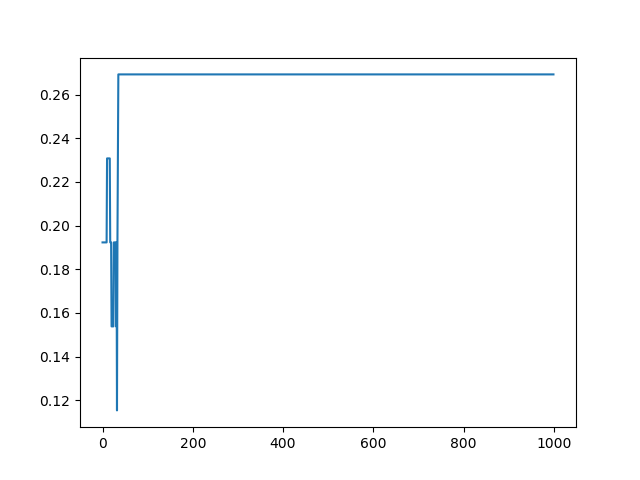

In [120]:
fig, ax = plt.subplots()
ax.plot(acc)
#ax.set_yscale('log')

<IPython.core.display.Javascript object>


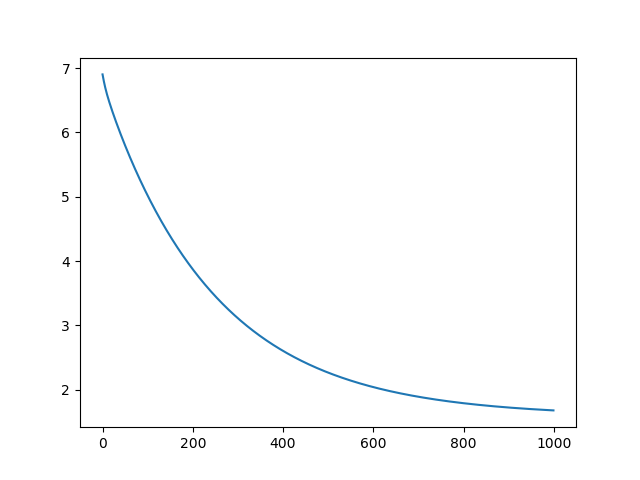

In [121]:
fig, ax = plt.subplots()
ax.plot(l)

In [122]:
acc[-1]

0.26923076923076922